In [27]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Các đường dẫn cho môi trường Kaggle
# Trên Kaggle, dữ liệu input thường nằm trong thư mục /kaggle/input/
# Bạn cần thay đổi tên dataset thực tế của bạn
DATASET_NAME = ""
BASE_DIR = f"/kaggle/input/oral-cancer/oral data set/Oral Cancer photos"
IMAGE_DIR = f"/kaggle/input/oral-cancer/oral data set/Oral Cancer photos"  # hoặc thư mục chứa ảnh gốc của bạn
MASK_DIR = f"/kaggle/input/oral-cancer/oral data set/Oral Cancer photos/masks"    # hoặc thư mục chứa mask của bạn

# Tạo thư mục đầu ra để lưu kết quả
OUTPUT_DIR = "/kaggle/working"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Đường dẫn dữ liệu ảnh: {IMAGE_DIR}")
print(f"Đường dẫn dữ liệu mask: {MASK_DIR}")

Đường dẫn dữ liệu ảnh: /kaggle/input/oral-cancer/oral data set/Oral Cancer photos
Đường dẫn dữ liệu mask: /kaggle/input/oral-cancer/oral data set/Oral Cancer photos/masks


In [28]:
# Các tham số cho mô hình
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
BATCH_SIZE = 16
EPOCHS = 50

# Hàm tạo mô hình U-Net
def build_unet_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    inputs = Input(input_shape)
    
    # Encoder path (Contracting path)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    
    # Bridge
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    # Decoder path (Expansive path)
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    
    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [29]:
# Hàm tải và tiền xử lý dữ liệu
def load_and_preprocess_data():
    print("Đang xử lý dữ liệu...")
    
    image_files = sorted([f for f in os.listdir(IMAGE_DIR) if f.endswith(('.png', '.jpg', '.jpeg', '.tif', '.bmp'))])
    
    X = []  # Danh sách ảnh gốc
    Y = []  # Danh sách mặt nạ (masks)
    
    for img_file in image_files:
        img_path = os.path.join(IMAGE_DIR, img_file)
        
        # Tùy chỉnh tên file mask dựa trên quy tắc đặt tên của dataset
        # Nếu mask có cùng tên với ảnh gốc
        base_name, ext = os.path.splitext(img_file)
        mask_file = f"{base_name}_mask.png"
        # Nếu mask có quy tắc đặt tên khác, hãy điều chỉnh đoạn code dưới đây
        # Ví dụ: nếu mask có định dạng "tên_file_mask.png" thay vì "tên_file.png"
        # mask_file = img_file.replace('.png', '_mask.png')
        
        mask_path = os.path.join(MASK_DIR, mask_file)
        
        # Kiểm tra xem file mask có tồn tại không
        if not os.path.exists(mask_path):
            print(f"Không tìm thấy mask cho ảnh: {img_file}")
            continue
        
        try:
            # Đọc và resize ảnh
            img = load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
            img = img_to_array(img) / 255.0  # Chuẩn hóa
            X.append(img)
            
            # Đọc và resize mask
            mask = load_img(mask_path, target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode="grayscale")
            mask = img_to_array(mask) / 255.0  # Chuẩn hóa
            mask = (mask > 0.5).astype(np.float32)  # Chuyển đổi thành nhị phân 0-1
            Y.append(mask)
        except Exception as e:
            print(f"Lỗi xử lý ảnh {img_file}: {str(e)}")
    
    X = np.array(X)
    Y = np.array(Y)
    
    print(f"Đã tải {len(X)} ảnh và masks")
    
    # Hiển thị một vài ví dụ để kiểm tra
    if len(X) > 0:
        plt.figure(figsize=(12, 6))
        for i in range(min(3, len(X))):
            plt.subplot(2, 3, i+1)
            plt.imshow(X[i])
            plt.title(f"Ảnh thứ {i+1}")
            plt.axis('off')
            
            plt.subplot(2, 3, i+4)
            plt.imshow(Y[i].squeeze(), cmap='gray')
            plt.title(f"Mask thứ {i+1}")
            plt.axis('off')
        
        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR, 'data_samples.png'))
        plt.show()
    
    return X, Y

# Hàm tạo data generator cho quá trình huấn luyện
def create_data_generator(X, Y, batch_size=BATCH_SIZE):
    while True:
        for i in range(0, len(X), batch_size):
            batch_X = X[i:i+batch_size]
            batch_Y = Y[i:i+batch_size]
            yield batch_X, batch_Y

# Hàm tăng cường dữ liệu (data augmentation)
def create_augmented_data_generator(X, Y, batch_size=BATCH_SIZE):
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    # Tạo seed để đảm bảo áp dụng cùng một biến đổi cho cả X và Y
    seed = 42
    
    # Generator cho X
    X_gen = datagen.flow(X, batch_size=batch_size, seed=seed)
    # Generator cho Y (mask)
    Y_gen = datagen.flow(Y, batch_size=batch_size, seed=seed)
    
    while True:
        X_batch = next(X_gen)
        Y_batch = next(Y_gen)
        yield X_batch, Y_batch

# Hàm huấn luyện mô hình
def train_model(X, Y):
    # Chia tập dữ liệu thành training và validation
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)
    
    print(f"Số lượng ảnh huấn luyện: {len(X_train)}")
    print(f"Số lượng ảnh kiểm tra: {len(X_val)}")
    
    # Khởi tạo mô hình
    model = build_unet_model()
    model.compile(optimizer=Adam(learning_rate=1e-4), 
                 loss='binary_crossentropy', 
                 metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)])
    
    model.summary()
    
    # Callbacks
    model_checkpoint = ModelCheckpoint(
        os.path.join(OUTPUT_DIR, 'unet_segmentation_model.h5'),
        monitor='val_loss',
        save_best_only=True,
        mode='min'
    )
    
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6
    )
    
    callbacks = [model_checkpoint, early_stopping, reduce_lr]
    
    # Sử dụng generator với data augmentation để huấn luyện
    train_generator = create_augmented_data_generator(X_train, Y_train)
    val_generator = create_data_generator(X_val, Y_val)
    
    steps_per_epoch = len(X_train) // BATCH_SIZE
    validation_steps = max(1, len(X_val) // BATCH_SIZE)
    
    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=EPOCHS,
        validation_data=val_generator,
        validation_steps=validation_steps,
        callbacks=callbacks
    )
    
    return model, history

In [30]:
def display_results(model, X_val, Y_val):
    # Đánh giá mô hình trên tập validation
    print("Đánh giá mô hình trên tập validation...")
    eval_results = model.evaluate(X_val, Y_val, verbose=1)
    
    print(f"Loss: {eval_results[0]:.4f}")
    print(f"Accuracy: {eval_results[1]:.4f}")
    if len(eval_results) > 2:
        print(f"Mean IoU: {eval_results[2]:.4f}")
    
    # Tính toán các chỉ số thống kê chi tiết
    print("\nTính toán chỉ số thống kê chi tiết...")
    predictions = model.predict(X_val)
    binary_predictions = (predictions > 0.5).astype(np.uint8)
    
    # Chuyển đổi tensor thành mảng numpy và làm phẳng để tính toán
    y_true = Y_val.squeeze().flatten()
    y_pred = binary_predictions.squeeze().flatten()
    
    # Tính true positives, false positives, true negatives, false negatives
    tp = np.sum((y_pred == 1) & (y_true == 1))
    fp = np.sum((y_pred == 1) & (y_true == 0))
    tn = np.sum((y_pred == 0) & (y_true == 0))
    fn = np.sum((y_pred == 0) & (y_true == 1))
    
    # Tính precision, recall, f1-score, specificity
    precision = tp / (tp + fp + 1e-7)  # Để tránh chia cho 0
    recall = tp / (tp + fn + 1e-7)     # Sensitivity
    specificity = tn / (tn + fp + 1e-7)
    f1_score = 2 * precision * recall / (precision + recall + 1e-7)
    
    # Tính Dice coefficient
    dice_coef = (2 * tp) / (2 * tp + fp + fn + 1e-7)
    
    # Tính Jaccard index (IoU) theo cách thủ công để kiểm tra
    iou = tp / (tp + fp + fn + 1e-7)
    
    # In các chỉ số
    print("\n===== CHỈ SỐ THỐNG KÊ MÔ HÌNH =====")
    print(f"Precision (Độ chính xác): {precision:.4f}")
    print(f"Recall/Sensitivity (Độ nhạy): {recall:.4f}")
    print(f"Specificity (Độ đặc hiệu): {specificity:.4f}")
    print(f"F1-Score: {f1_score:.4f}")
    print(f"Dice Coefficient: {dice_coef:.4f}")
    print(f"IoU (Jaccard Index): {iou:.4f}")
    
    # Tạo ma trận nhầm lẫn (confusion matrix)
    conf_matrix = np.array([[tn, fp], [fn, tp]])
    
    print("\nConfusion Matrix:")
    print(f"TN: {tn}, FP: {fp}")
    print(f"FN: {fn}, TP: {tp}")
    
    # Vẽ ma trận nhầm lẫn
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    
    classes = ['Background (0)', 'Object (1)']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Hiển thị số liệu trong ma trận
    thresh = conf_matrix.max() / 2.
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, format(conf_matrix[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if conf_matrix[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrix.png'))
    
    # Lưu các chỉ số vào file
    with open(os.path.join(OUTPUT_DIR, 'model_metrics.txt'), 'w') as f:
        f.write("===== CHỈ SỐ THỐNG KÊ MÔ HÌNH =====\n")
        f.write(f"Loss: {eval_results[0]:.4f}\n")
        f.write(f"Accuracy: {eval_results[1]:.4f}\n")
        if len(eval_results) > 2:
            f.write(f"Mean IoU: {eval_results[2]:.4f}\n")
        f.write(f"Precision (Độ chính xác): {precision:.4f}\n")
        f.write(f"Recall/Sensitivity (Độ nhạy): {recall:.4f}\n")
        f.write(f"Specificity (Độ đặc hiệu): {specificity:.4f}\n")
        f.write(f"F1-Score: {f1_score:.4f}\n")
        f.write(f"Dice Coefficient: {dice_coef:.4f}\n")
        f.write(f"IoU (Jaccard Index): {iou:.4f}\n")
    
    # Chọn một số ảnh ngẫu nhiên để hiển thị kết quả
    num_samples = min(5, len(X_val))
    indices = np.random.choice(len(X_val), num_samples, replace=False)
    
    plt.figure(figsize=(15, 5 * num_samples))
    
    for i, idx in enumerate(indices):
        # Dự đoán mask
        prediction = model.predict(np.expand_dims(X_val[idx], axis=0))[0]
        binary_prediction = (prediction > 0.5).astype(np.uint8)
        
        # Hiển thị ảnh gốc
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(X_val[idx])
        plt.title("Ảnh gốc")
        plt.axis('off')
        
        # Hiển thị mask thực tế
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(Y_val[idx].squeeze(), cmap='gray')
        plt.title("Mask thực tế")
        plt.axis('off')
        
        # Hiển thị mask dự đoán
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(binary_prediction.squeeze(), cmap='gray')
        plt.title("Mask dự đoán")
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'segmentation_results.png'))
    plt.show()

def main():
    # Tải và tiền xử lý dữ liệu
    X, Y = load_and_preprocess_data()
    
    if len(X) == 0:
        print("Không tìm thấy dữ liệu ảnh và mask. Vui lòng kiểm tra đường dẫn.")
        return
    
    # Huấn luyện mô hình
    model, history = train_model(X, Y)
    
    # Đánh giá và hiển thị kết quả
    _, X_val, _, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)
    display_results(model, X_val, Y_val)
    
    # Lưu mô hình
    model.save(os.path.join(OUTPUT_DIR, 'unet_final_model.h5'))
    print(f"Đã lưu mô hình tại: {os.path.join(OUTPUT_DIR, 'unet_final_model.h5')}")
    
    # Vẽ biểu đồ quá trình huấn luyện
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'training_history.png'))
    plt.show()
    
    # Hiển thị IoU nếu có
    if 'mean_io_u' in history.history:
        plt.figure(figsize=(8, 5))
        plt.plot(history.history['mean_io_u'], label='Training IoU')
        plt.plot(history.history['val_mean_io_u'], label='Validation IoU')
        plt.title('Mean IoU over epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Mean IoU')
        plt.legend()
        plt.savefig(os.path.join(OUTPUT_DIR, 'iou_history.png'))
        plt.show()

In [31]:
# Hàm dự đoán cho một ảnh mới
def predict_mask(model, image_path):
    # Tải và tiền xử lý ảnh
    img = load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = img_to_array(img) / 255.0
    
    # Dự đoán mask
    prediction = model.predict(np.expand_dims(img_array, axis=0))[0]
    binary_prediction = (prediction > 0.5).astype(np.uint8)
    
    # Hiển thị kết quả
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Ảnh gốc")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(binary_prediction.squeeze(), cmap='gray')
    plt.title("Mask dự đoán")
    plt.axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'prediction.png'))
    plt.show()
    
    return binary_prediction

Đang xử lý dữ liệu...
Không tìm thấy mask cho ảnh: 094.jpeg
Đã tải 653 ảnh và masks


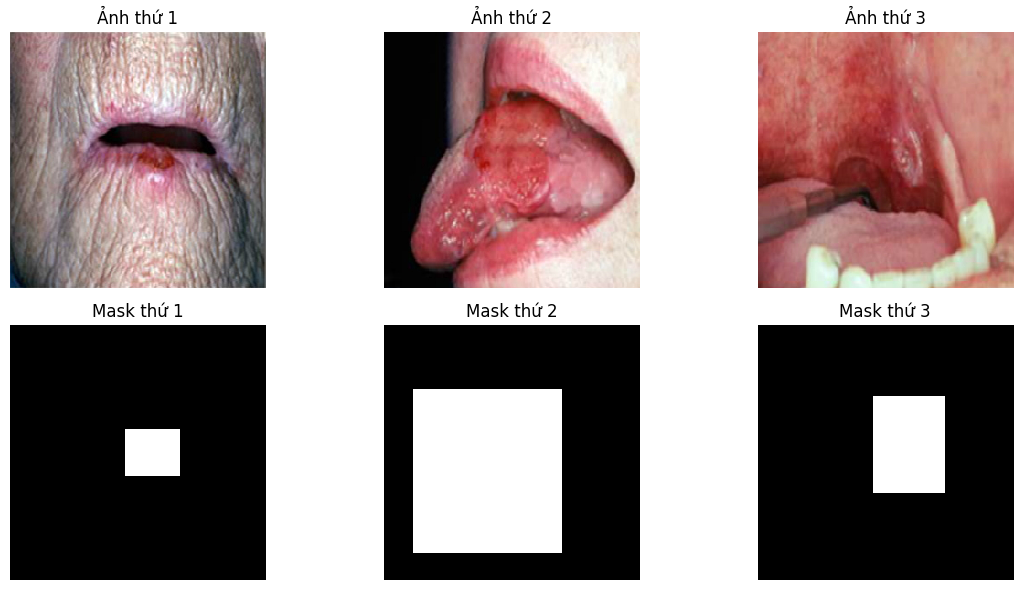

Số lượng ảnh huấn luyện: 522
Số lượng ảnh kiểm tra: 131


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_38 (Conv2D)        │ (None, 256, 256, 16)   │            448 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_39 (Conv2D)        │ (None, 256, 256, 16)   │          2,320 │ conv2d_38[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 128, 128, 16)   │              0 │ conv2d_39[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_40 (Conv2D)        │ (None, 128, 128, 32)   │          4,640 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_41 (Conv2D)        │ (None, 128, 128, 32)   │          9,248 │ conv2d_40[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_9           │ (None, 64, 64, 32)     │              0 │ conv2d_41[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_42 (Conv2D)        │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_43 (Conv2D)        │ (None, 64, 64, 64)     │         36,928 │ conv2d_42[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_10          │ (None, 32, 32, 64)     │              0 │ conv2d_43[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_44 (Conv2D)        │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_10[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_45 (Conv2D)        │ (None, 32, 32, 128)    │        147,584 │ conv2d_44[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_11          │ (None, 16, 16, 128)    │              0 │ conv2d_45[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_46 (Conv2D)        │ (None, 16, 16, 256)    │        295,168 │ max_pooling2d_11[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_47 (Conv2D)        │ (None, 16, 16, 256)    │        590,080 │ conv2d_46[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_8        │ (None, 32, 32, 128)    │        131,200 │ conv2d_47[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_8        

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 314ms/step - accuracy: 0.6972 - loss: 0.6049 - mean_io_u_2: 0.4078 - val_accuracy: 0.8136 - val_loss: 0.5053 - val_mean_io_u_2: 0.4069 - learning_rate: 1.0000e-04
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 269ms/step - accuracy: 0.8184 - loss: 0.4883 - mean_io_u_2: 0.4134 - val_accuracy: 0.8098 - val_loss: 0.4426 - val_mean_io_u_2: 0.4049 - learning_rate: 1.0000e-04
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 295ms/step - accuracy: 0.8107 - loss: 0.4321 - mean_io_u_2: 0.4096 - val_accuracy: 0.8010 - val_loss: 0.4348 - val_mean_io_u_2: 0.4005 - learning_rate: 1.0000e-04
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 255ms/step - accuracy: 0.8195 - loss: 0.4172 - mean_io_u_2: 0.4140 - val_accuracy: 0.8122 - val_loss: 0.4212 - val_mean_io_u_2: 0.4061 - learning_rate: 1.0000e-04
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 273ms/step - accuracy: 0.8129 - loss: 0.4161 - mean_io_u_2: 0.4108 - val_accuracy: 0.8152 - val_loss: 0.4023 - val_mean_io_u_2: 0.4076 - lear

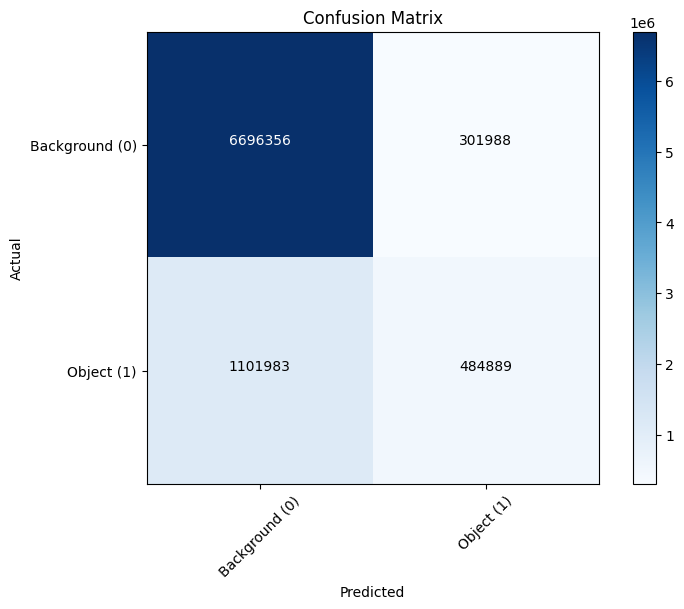

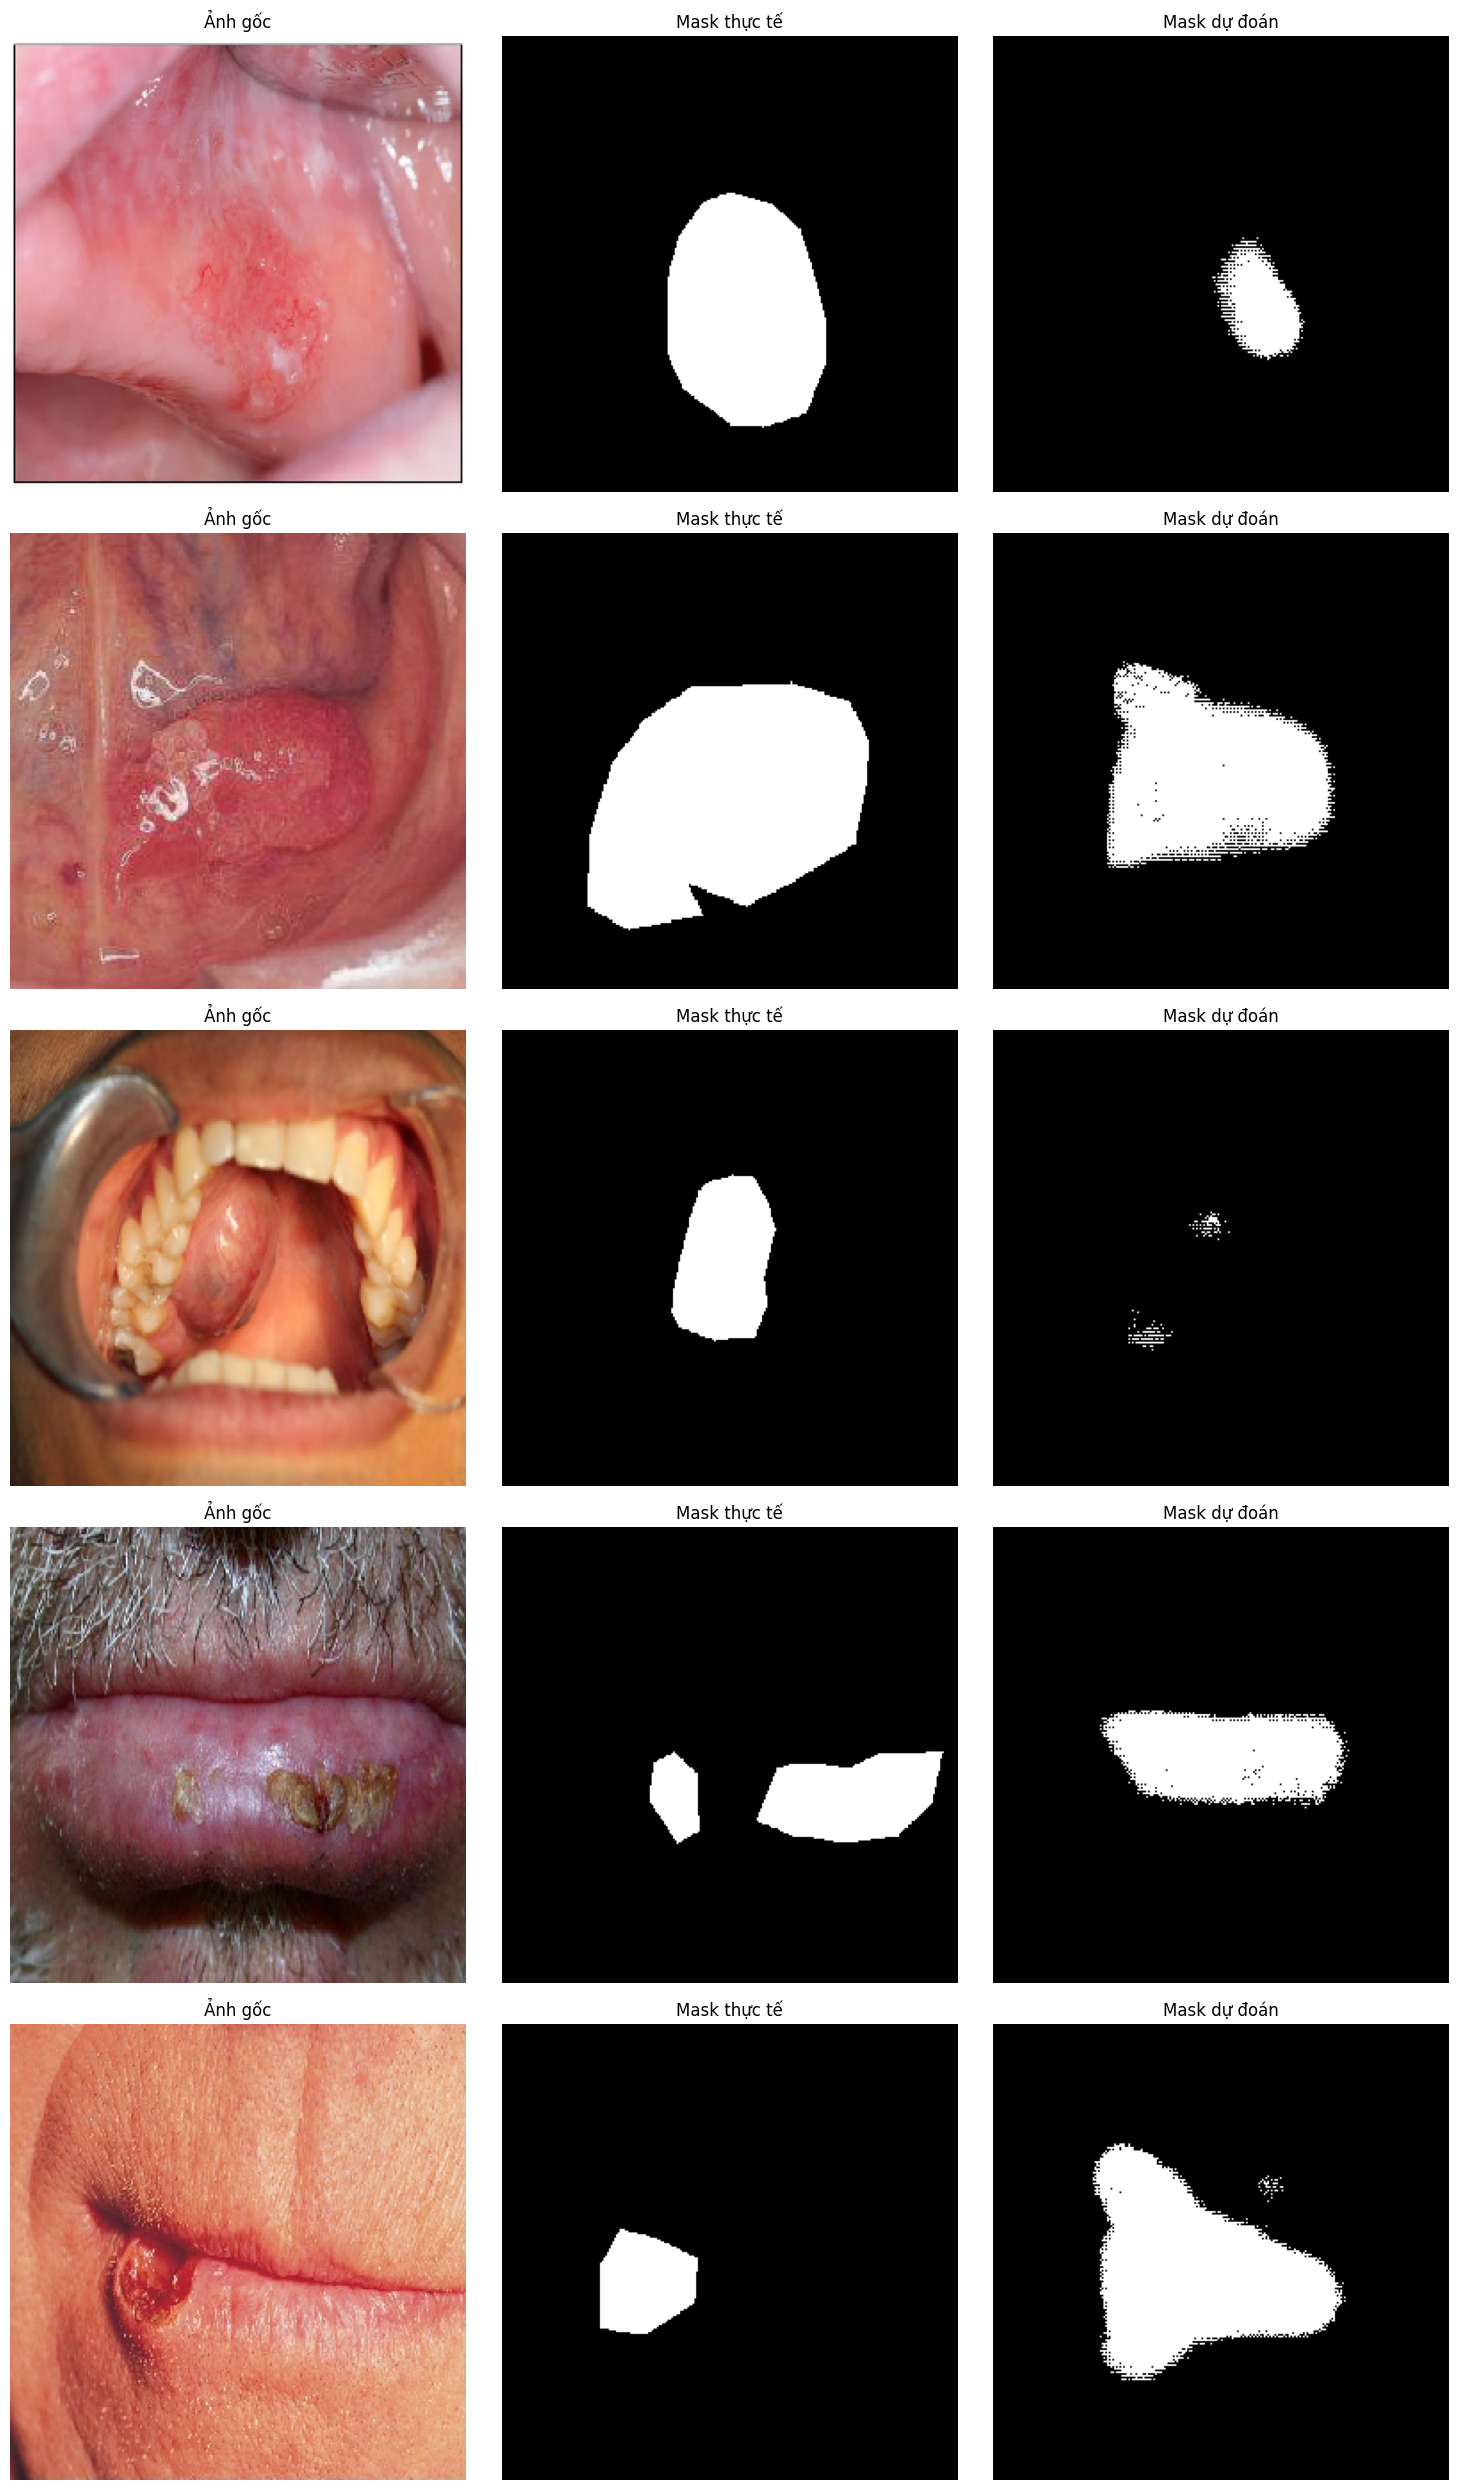

Đã lưu mô hình tại: /kaggle/working/unet_final_model.h5


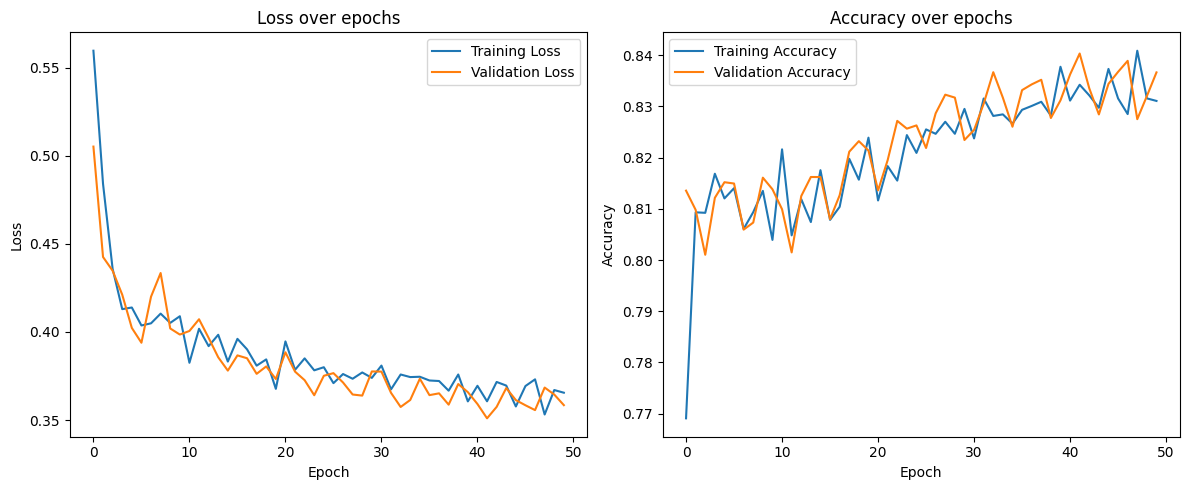

In [32]:
if __name__ == "__main__":
    main()

2025-05-20 09:15:51.887674: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747732551.910273      82 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747732551.917148      82 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1747732563.080896      82 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747732563.081642      82 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability:

Đang tải dữ liệu...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Đã tải 653 ảnh và masks
Số lượng ảnh huấn luyện: 457
Số lượng ảnh validation: 98
Số lượng ảnh test: 98

Đánh giá mô hình trên tập test...


I0000 00:00:1747732585.535817     117 service.cc:148] XLA service 0x7ae0001061f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747732585.537440     117 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1747732585.537475     117 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1747732585.853132     117 cuda_dnn.cc:529] Loaded cuDNN version 90300


3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8598 - loss: 0.3142 - mean_io_u_5: 0.4016

I0000 00:00:1747732593.166742     117 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 946ms/step - accuracy: 0.8622 - loss: 0.3108 - mean_io_u_5: 0.4043

Loss: 0.3057
Accuracy: 0.8658
Mean IoU: 0.4083
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 366ms/step

===== CHỈ SỐ THỐNG KÊ MÔ HÌNH TRÊN TẬP TEST =====
Precision (Độ chính xác): 0.6593
Recall/Sensitivity (Độ nhạy): 0.5557
Specificity (Độ đặc hiệu): 0.9355
F1-Score: 0.6031
Dice Coefficient: 0.6031
IoU (Jaccard Index): 0.4317

Confusion Matrix:
TN: 4906361, FP: 338201
FN: 523382, TP: 654584


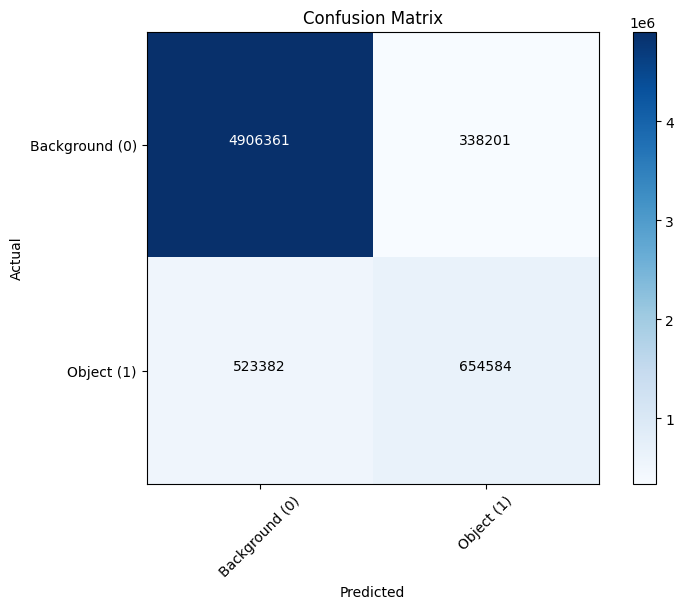

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


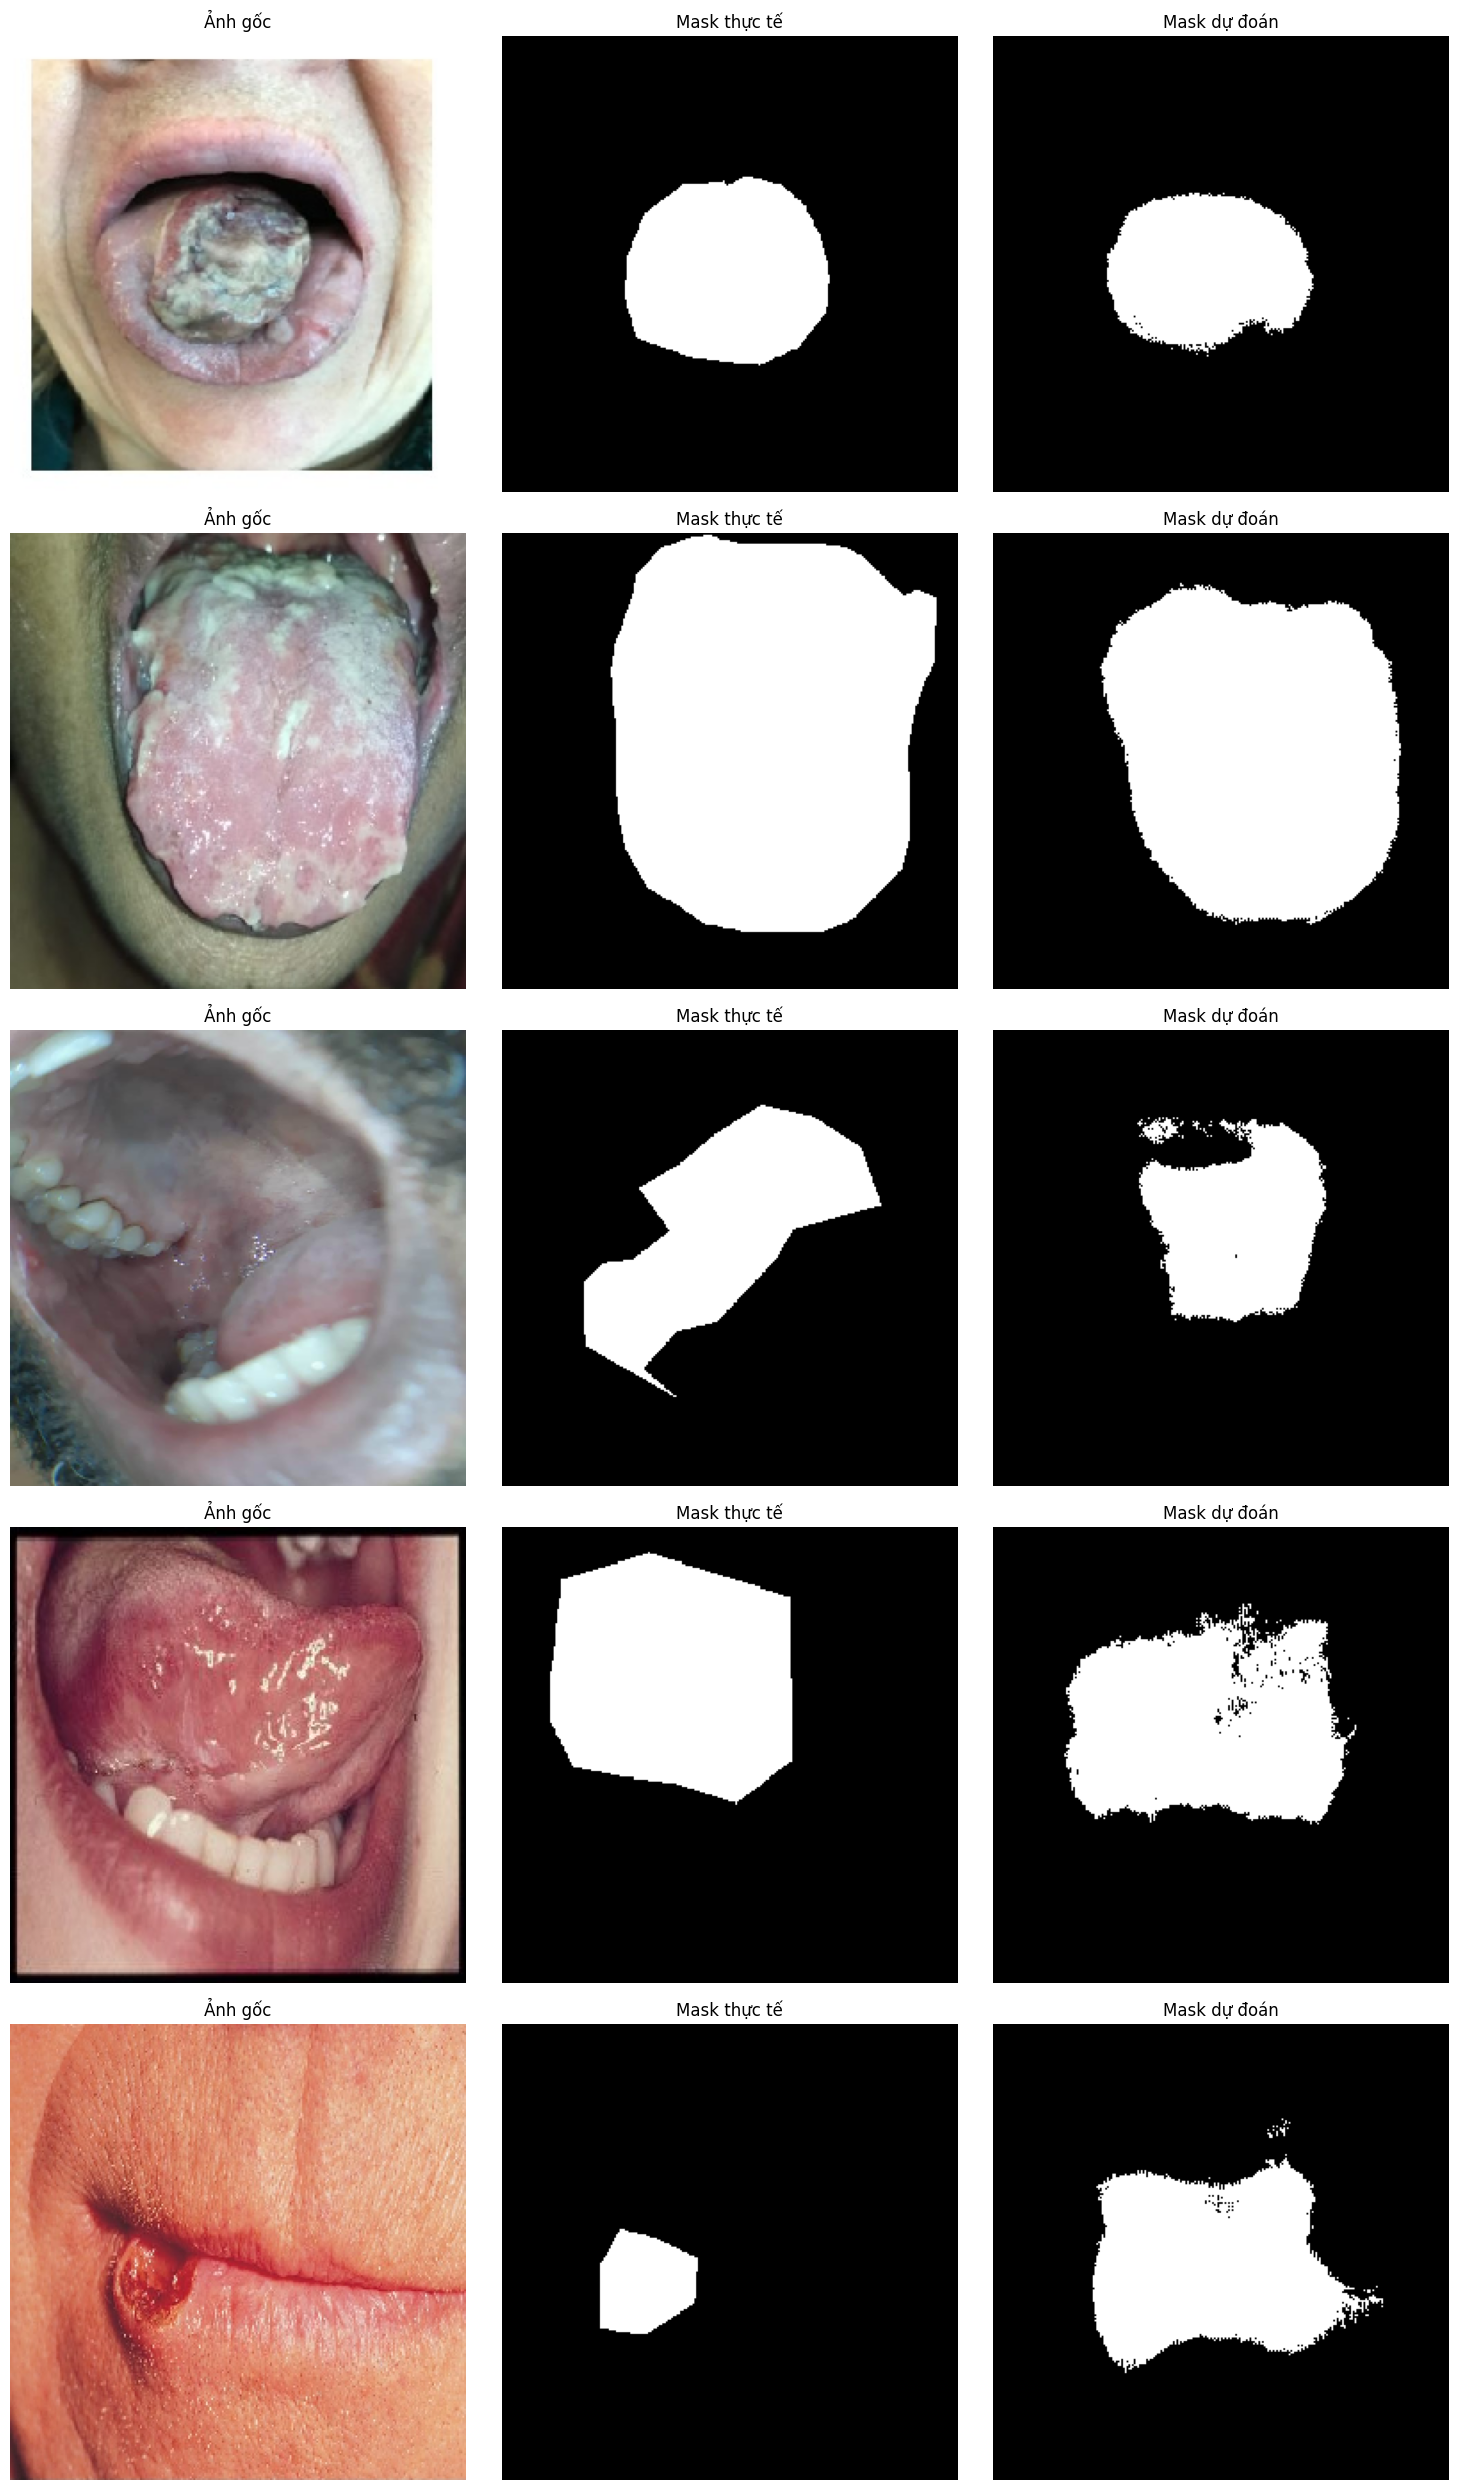

Đã lưu kết quả đánh giá vào thư mục: /kaggle/working


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Thiết lập thông số
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 3
OUTPUT_DIR = "/kaggle/working"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Đường dẫn dữ liệu
IMAGE_DIR = "/kaggle/input/oral-cancer/oral data set/Oral Cancer photos"
MASK_DIR = "/kaggle/input/oral-cancer/oral data set/Oral Cancer photos/masks"

# Đường dẫn mô hình đã lưu
MODEL_PATH = "/kaggle/input/unet/other/default/1/unet_final_model.h5"

# Tải mô hình đã huấn luyện
model = load_model(MODEL_PATH)

# Tải và tiền xử lý dữ liệu
print("Đang tải dữ liệu...")
image_files = sorted([f for f in os.listdir(IMAGE_DIR) if f.endswith(('.png', '.jpg', '.jpeg', '.tif', '.bmp'))])

X = []  # Danh sách ảnh gốc
Y = []  # Danh sách mặt nạ (masks)

for img_file in image_files:
    img_path = os.path.join(IMAGE_DIR, img_file)
    
    # Tìm file mask tương ứng
    base_name, ext = os.path.splitext(img_file)
    mask_file = f"{base_name}_mask.png"
    mask_path = os.path.join(MASK_DIR, mask_file)
    
    if not os.path.exists(mask_path):
        continue
    
    # Đọc và tiền xử lý ảnh
    img = load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img = img_to_array(img) / 255.0  # Chuẩn hóa
    X.append(img)
    
    # Đọc và tiền xử lý mask
    mask = load_img(mask_path, target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode="grayscale")
    mask = img_to_array(mask) / 255.0  # Chuẩn hóa
    mask = (mask > 0.5).astype(np.float32)  # Chuyển đổi thành nhị phân 0-1
    Y.append(mask)

X = np.array(X)
Y = np.array(Y)
print(f"Đã tải {len(X)} ảnh và masks")

# Chia dữ liệu thành tập train, validation và test (70%, 15%, 15%)
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.1765, random_state=42)  # ~15% của tổng

print(f"Số lượng ảnh huấn luyện: {len(X_train)}")
print(f"Số lượng ảnh validation: {len(X_val)}")
print(f"Số lượng ảnh test: {len(X_test)}")

# Đánh giá mô hình trên tập test
print("\nĐánh giá mô hình trên tập test...")
test_results = model.evaluate(X_test, Y_test, verbose=1)

# In kết quả đánh giá
print(f"\nLoss: {test_results[0]:.4f}")
print(f"Accuracy: {test_results[1]:.4f}")
if len(test_results) > 2:
    print(f"Mean IoU: {test_results[2]:.4f}")

# Dự đoán mask trên tập test
predictions = model.predict(X_test)
binary_predictions = (predictions > 0.5).astype(np.uint8)

# Tính toán các chỉ số thống kê chi tiết
y_true = Y_test.squeeze().flatten()
y_pred = binary_predictions.squeeze().flatten()

# Tính true positives, false positives, true negatives, false negatives
tp = np.sum((y_pred == 1) & (y_true == 1))
fp = np.sum((y_pred == 1) & (y_true == 0))
tn = np.sum((y_pred == 0) & (y_true == 0))
fn = np.sum((y_pred == 0) & (y_true == 1))

# Tính precision, recall, f1-score, specificity
precision = tp / (tp + fp + 1e-7)  # Để tránh chia cho 0
recall = tp / (tp + fn + 1e-7)     # Sensitivity
specificity = tn / (tn + fp + 1e-7)
f1_score = 2 * precision * recall / (precision + recall + 1e-7)

# Tính Dice coefficient
dice_coef = (2 * tp) / (2 * tp + fp + fn + 1e-7)

# Tính Jaccard index (IoU)
iou = tp / (tp + fp + fn + 1e-7)

# In các chỉ số thống kê
print("\n===== CHỈ SỐ THỐNG KÊ MÔ HÌNH TRÊN TẬP TEST =====")
print(f"Precision (Độ chính xác): {precision:.4f}")
print(f"Recall/Sensitivity (Độ nhạy): {recall:.4f}")
print(f"Specificity (Độ đặc hiệu): {specificity:.4f}")
print(f"F1-Score: {f1_score:.4f}")
print(f"Dice Coefficient: {dice_coef:.4f}")
print(f"IoU (Jaccard Index): {iou:.4f}")

# Tạo ma trận nhầm lẫn (confusion matrix)
conf_matrix = np.array([[tn, fp], [fn, tp]])

print("\nConfusion Matrix:")
print(f"TN: {tn}, FP: {fp}")
print(f"FN: {fn}, TP: {tp}")

# Vẽ ma trận nhầm lẫn
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = ['Background (0)', 'Object (1)']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Hiển thị số liệu trong ma trận
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                horizontalalignment="center",
                color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig(os.path.join(OUTPUT_DIR, 'test_confusion_matrix.png'))
plt.show()

# Lưu các chỉ số vào file
with open(os.path.join(OUTPUT_DIR, 'test_model_metrics.txt'), 'w') as f:
    f.write("===== CHỈ SỐ THỐNG KÊ MÔ HÌNH TRÊN TẬP TEST =====\n")
    f.write(f"Loss: {test_results[0]:.4f}\n")
    f.write(f"Accuracy: {test_results[1]:.4f}\n")
    if len(test_results) > 2:
        f.write(f"Mean IoU: {test_results[2]:.4f}\n")
    f.write(f"Precision (Độ chính xác): {precision:.4f}\n")
    f.write(f"Recall/Sensitivity (Độ nhạy): {recall:.4f}\n")
    f.write(f"Specificity (Độ đặc hiệu): {specificity:.4f}\n")
    f.write(f"F1-Score: {f1_score:.4f}\n")
    f.write(f"Dice Coefficient: {dice_coef:.4f}\n")
    f.write(f"IoU (Jaccard Index): {iou:.4f}\n")

# Hiển thị một số ảnh dự đoán
num_samples = min(5, len(X_test))
indices = np.random.choice(len(X_test), num_samples, replace=False)

plt.figure(figsize=(15, 5 * num_samples))

for i, idx in enumerate(indices):
    # Dự đoán mask
    prediction = model.predict(np.expand_dims(X_test[idx], axis=0))[0]
    binary_prediction = (prediction > 0.5).astype(np.uint8)
    
    # Hiển thị ảnh gốc
    plt.subplot(num_samples, 3, i * 3 + 1)
    plt.imshow(X_test[idx])
    plt.title("Ảnh gốc")
    plt.axis('off')
    
    # Hiển thị mask thực tế
    plt.subplot(num_samples, 3, i * 3 + 2)
    plt.imshow(Y_test[idx].squeeze(), cmap='gray')
    plt.title("Mask thực tế")
    plt.axis('off')
    
    # Hiển thị mask dự đoán
    plt.subplot(num_samples, 3, i * 3 + 3)
    plt.imshow(binary_prediction.squeeze(), cmap='gray')
    plt.title("Mask dự đoán")
    plt.axis('off')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'test_segmentation_results.png'))
plt.show()

print(f"Đã lưu kết quả đánh giá vào thư mục: {OUTPUT_DIR}")